In [1]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls


# Initialize findspark
import findspark
findspark.init()



# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("BD Project") \
        .getOrCreate()


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,069 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,373 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backport

In [13]:
import pandas as pd
df = pd.read_csv('/content/full_combined_data.csv')
df.shape

<ipython-input-13-248241a97ac1>:2: DtypeWarning: Columns (7,8,10,11,30,49,55,73,80,91,107,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/full_combined_data.csv')


(35444, 118)

In [14]:
selected_columns = [
    'author',  'domain',
    'num_comments', 'score', 'selftext',
    'subreddit_subscribers', 'title', 'upvote_ratio','subreddit'
]

df=df[selected_columns]
df.head()

,author,domain,num_comments,score,selftext,subreddit_subscribers,title,upvote_ratio,subreddit
0,Sorry_Lettuce_507,self.travel,4,1,I’m from the U.S for whenever I travel it’s ve...,9372332,Can’t decide where to go,0.60,travel
1,RichardMeans,reddit.com,0,1,NaN,9372310,It a good day here,1.00,travel
2,Prudent_Storm_3781,self.travel,52,4,I’m going to hit Rome and sorrento for two wee...,9372311,Italy advice…what to cut out? First trip,0.65,travel
3,wildchildplaygroup,self.travel,1,1,[removed],9372289,Should I take Dukoral before Mexico trip?,1.00,travel
4,mirzaeian,self.travel,11,0,I do travel a lot but I am not a fan of touris...,9372289,is there a map that I can find travel destinat...,0.44,travel


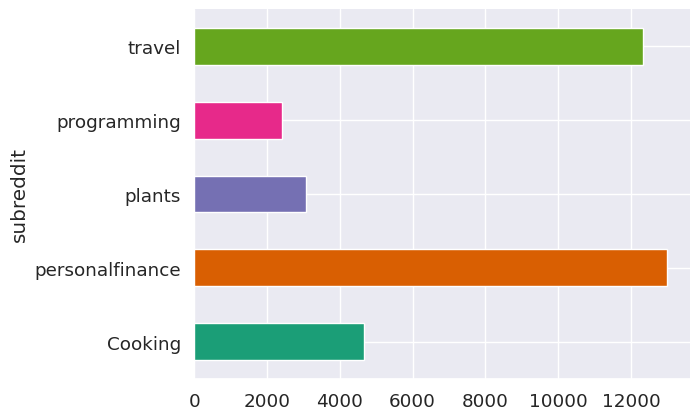

In [15]:
# @title subreddit

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('subreddit').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Pandas to spark

In [16]:
from pyspark.sql.types import StructType, StructField, StringType
# Convert the pandas DataFrame to a list of tuples
data_tuples = [tuple(x) for x in df.values]

# Define the schema for the Spark DataFrame
schema = StructType([StructField(column_name, StringType(), True) for column_name in selected_columns])

# Create a Spark DataFrame from the list of tuples using the defined schema
spark_df = spark.createDataFrame(data_tuples, schema)


In [17]:
row_count = spark_df.count()

# Count the number of columns
column_count = len(spark_df.columns)

print(f"Number of rows: {row_count}")
print(f"Number of columns: {column_count}")


Number of rows: 35444
Number of columns: 9


In [18]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Convert columns to correct data types
spark_df = spark_df.withColumn("num_comments", spark_df["num_comments"].cast(IntegerType()))
spark_df = spark_df.withColumn("score", spark_df["score"].cast(IntegerType()))
spark_df = spark_df.withColumn("subreddit_subscribers", spark_df["subreddit_subscribers"].cast(IntegerType()))
spark_df = spark_df.withColumn("upvote_ratio", spark_df["upvote_ratio"].cast(FloatType()))

# Selecting numerical columns
numerical_cols = ['num_comments', 'score', 'subreddit_subscribers', 'upvote_ratio']

# Initialize MinMaxScaler
scaler = MinMaxScaler(inputCol="scaled_features", outputCol="scaled_features_normalized")

# Assemble numerical columns into a vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="scaled_features")
assembled_df = assembler.transform(spark_df)

# Compute summary statistics and generate the scaler model
scaler_model = scaler.fit(assembled_df)

# Scale the features directly in the same DataFrame
scaled_df_normalized = scaler_model.transform(assembled_df)

# Show the DataFrame with normalized features
scaled_df_normalized.show(5)


+------------------+-----------+------------+-----+--------------------+---------------------+--------------------+------------+---------+--------------------+--------------------------+
|            author|     domain|num_comments|score|            selftext|subreddit_subscribers|               title|upvote_ratio|subreddit|     scaled_features|scaled_features_normalized|
+------------------+-----------+------------+-----+--------------------+---------------------+--------------------+------------+---------+--------------------+--------------------------+
| Sorry_Lettuce_507|self.travel|           4|    1|I’m from the U.S ...|              9372332|Can’t decide wher...|         0.6|   travel|[4.0,1.0,9372332....|      [9.23147934456496...|
|      RichardMeans| reddit.com|           0|    1|                 NaN|              9372310|  It a good day here|         1.0|   travel|[0.0,1.0,9372310....|      [0.0,1.1996161228...|
|Prudent_Storm_3781|self.travel|          52|    4|I’m going to h

In [19]:

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
# Apply Tokenizer to tokenize the title column
tokenizer = Tokenizer(inputCol="title", outputCol="words")
words_data = tokenizer.transform(scaled_df_normalized)

# Apply HashingTF to convert words to feature vectors
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurized_data = hashing_tf.transform(words_data)

# Apply IDF to scale the raw features
idf = IDF(inputCol="rawFeatures", outputCol="tf_idf_features")
idf_model = idf.fit(featurized_data)
tf_idf_data = idf_model.transform(featurized_data)

# Show the DataFrame with TF-IDF features
tf_idf_data.select("title", "tf_idf_features").show(5)


+--------------------+--------------------+
|               title|     tf_idf_features|
+--------------------+--------------------+
|Can’t decide wher...|(20,[6,8,11,13,18...|
|  It a good day here|(20,[6,7,8,13,15]...|
|Italy advice…what...|(20,[2,3,4,6,8,10...|
|Should I take Duk...|(20,[0,1,11,15,16...|
|is there a map th...|(20,[0,1,2,7,8,9,...|
+--------------------+--------------------+
only showing top 5 rows



In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# StringIndexer to convert subreddit column to numeric labels
indexer = StringIndexer(inputCol="subreddit", outputCol="label")
indexed_df = indexer.fit(tf_idf_data).transform(tf_idf_data)

# OneHotEncoder to convert numeric labels to one-hot encoded vectors
encoder = OneHotEncoder(inputCol="label", outputCol="encoded_label")
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

# Show the DataFrame with one-hot encoded labels
encoded_df.select("subreddit", "label", "encoded_label").show(5)


+---------+-----+-------------+
|subreddit|label|encoded_label|
+---------+-----+-------------+
|   travel|  1.0|(4,[1],[1.0])|
|   travel|  1.0|(4,[1],[1.0])|
|   travel|  1.0|(4,[1],[1.0])|
|   travel|  1.0|(4,[1],[1.0])|
|   travel|  1.0|(4,[1],[1.0])|
+---------+-----+-------------+
only showing top 5 rows



In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
lr_accuracy = evaluator.evaluate(predictions)

# Print the accuracy of test data
print("Accuracy:", lr_accuracy)



Accuracy: 0.8475962216269561


Training Precision: 0.7361339921837844
Training Recall: 0.8449437409615181
Training F1 Score: 0.7810035891699936

Test Precision: 0.7394677682797819
Test Recall: 0.8475962216269561
Test F1 Score: 0.7843442211702929


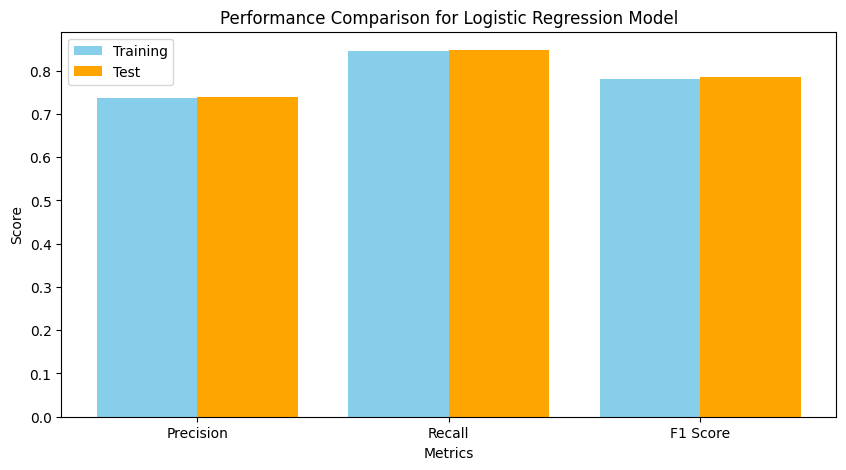

<Figure size 640x480 with 0 Axes>

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on both training and test data
train_predictions = lr_model.transform(train_data)
test_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Compute precision, recall, and F1 score for training data
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"})
train_f1_score = evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"})

# Compute precision, recall, and F1 score for test data
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})

# Print precision, recall, and F1 score
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)
print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

# Plot performance for training and test data
labels = ["Precision", "Recall", "F1 Score"]
train_scores = [train_precision, train_recall, train_f1_score]
test_scores = [test_precision, test_recall, test_f1_score]

x = range(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x, train_scores, width=0.4, label="Training", color='skyblue')
plt.bar([i + 0.4 for i in x], test_scores, width=0.4, label="Test", color='orange')
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Performance Comparison for Logistic Regression Model")
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()
plt.show()
plt.savefig('Performance Comparison for Logistic Regression Model.png', dpi=300)

LR VALID

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_data, val_data, test_data = assembled_df.randomSplit([0.6, 0.2, 0.2], seed=1234)

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on validation and test data
val_predictions = lr_model.transform(val_data)
test_predictions = lr_model.transform(test_data)

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# Evaluate the model on validation data
val_accuracy = evaluator.evaluate(val_predictions)
val_precision = evaluator.evaluate(val_predictions, {evaluator.metricName: "weightedPrecision"})
val_recall = evaluator.evaluate(val_predictions, {evaluator.metricName: "weightedRecall"})
val_f1_score = evaluator.evaluate(val_predictions, {evaluator.metricName: "f1"})

# Evaluate the model on test data
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})

# Print evaluation results
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1_score)

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1_score)

Validation Metrics:
Accuracy: 0.8423201464170069
Precision: 0.7325257147464195
Recall: 0.8423201464170069
F1 Score: 0.7775947845242437

Test Metrics:
Accuracy: 0.8475962216269561
Precision: 0.7394677682797819
Recall: 0.8475962216269561
F1 Score: 0.7843442211702929


In [17]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.3], seed=1234)

# Initialize Decision Tree Classifier model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)

# Fit the model on the training data
dt_model = dt.fit(train_data)

# Make predictions on the test data
predictions = dt_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Decision Tree Classifier Accuracy:", accuracy)


Decision Tree Classifier Accuracy: 1.0


In [18]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize Random Forest Classifier model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10)

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
rf_accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Random Forest Classifier Accuracy:", rf_accuracy)


Random Forest Classifier Accuracy: 0.9918229240095869


Training Accuracy: 0.991804836450838
Training Precision: 0.9921209299392659
Training Recall: 0.9920284998765475
Training F1 Score: 0.991804836450838

Test Accuracy: 0.991586606459762
Test Precision: 0.9919239119862122
Test Recall: 0.9918229240095869
Test F1 Score: 0.991586606459762


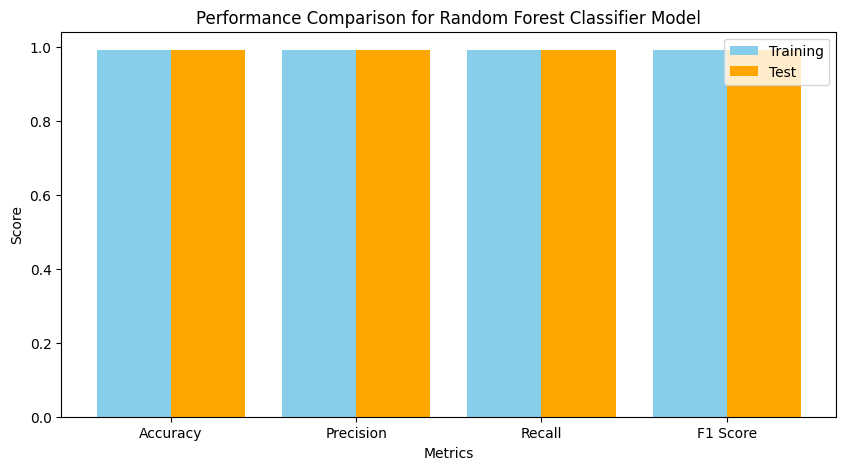

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassificationModel

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Compute precision, recall, and F1 score for training data
train_accuracy = evaluator.evaluate(rf_model.transform(train_data))
train_predictions = rf_model.transform(train_data)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"})
train_f1_score = evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"})

# Compute precision, recall, and F1 score for test data
test_accuracy = evaluator.evaluate(predictions)
test_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print precision, recall, and F1 score
print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)
print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

# Plot performance for training and test data
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
train_scores = [train_accuracy, train_precision, train_recall, train_f1_score]
test_scores = [test_accuracy, test_precision, test_recall, test_f1_score]

x = range(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x, train_scores, width=0.4, label="Training", color='skyblue')
plt.bar([i + 0.4 for i in x], test_scores, width=0.4, label="Test", color='orange')
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Performance Comparison for Random Forest Classifier Model")
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()
plt.show()


RF VALID

In [11]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training, validation, and test sets (80% train, 10% validation, 10% test)
train_data, test_data, valid_data = assembled_df.randomSplit([0.8, 0.1, 0.1], seed=1234)

# Initialize Random Forest Classifier model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10)

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Make predictions on the training, validation, and test data
train_predictions = rf_model.transform(train_data)
valid_predictions = rf_model.transform(valid_data)
test_predictions = rf_model.transform(test_data)

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Evaluate the model on training data
train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"})
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"})
train_f1_score = evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"})

# Evaluate the model on validation data
valid_accuracy = evaluator.evaluate(valid_predictions, {evaluator.metricName: "accuracy"})
valid_precision = evaluator.evaluate(valid_predictions, {evaluator.metricName: "weightedPrecision"})
valid_recall = evaluator.evaluate(valid_predictions, {evaluator.metricName: "weightedRecall"})
valid_f1_score = evaluator.evaluate(valid_predictions, {evaluator.metricName: "f1"})

# Evaluate the model on test data
test_accuracy = evaluator.evaluate(test_predictions, {evaluator.metricName: "accuracy"})
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})

# Print evaluation results
print("Training Metrics:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1 Score:", train_f1_score)

print("\nValidation Metrics:")
print("Accuracy:", valid_accuracy)
print("Precision:", valid_precision)
print("Recall:", valid_recall)
print("F1 Score:", valid_f1_score)

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1_score)


Training Metrics:
Accuracy: 0.9936510176007901
Precision: 0.993720478001421
Recall: 0.9936510176007901
F1 Score: 0.9935138043869206

Validation Metrics:
Accuracy: 0.99237072619384
Precision: 0.9924622145100714
Recall: 0.99237072619384
F1 Score: 0.9921703319020286

Test Metrics:
Accuracy: 0.9907146876758582
Precision: 0.9908390390154266
Recall: 0.9907146876758582
F1 Score: 0.9904001637153073


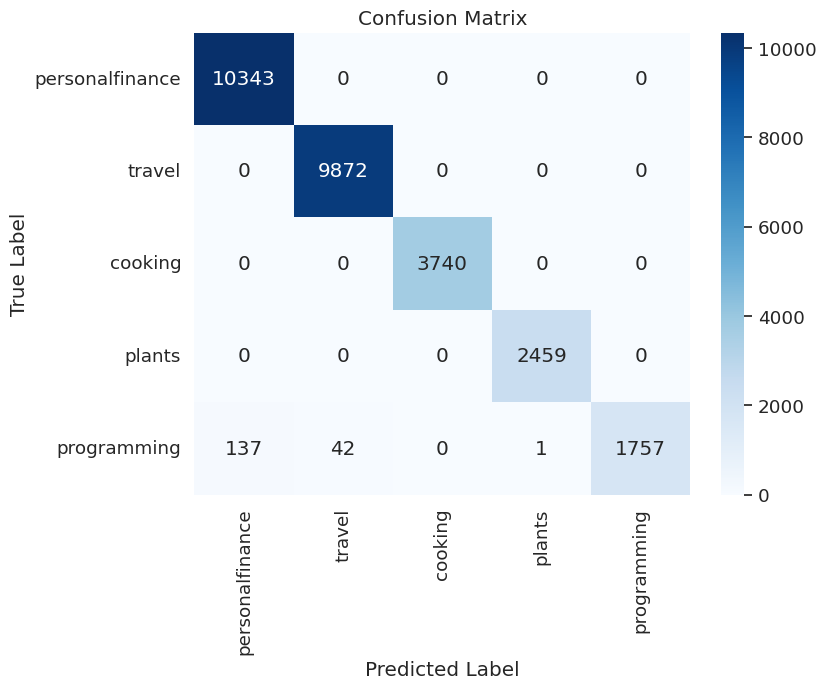

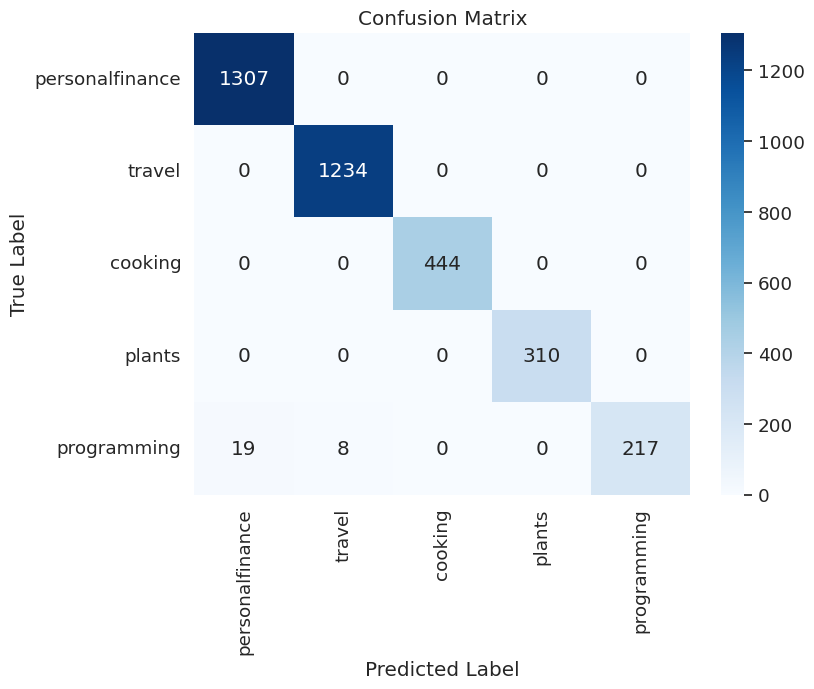

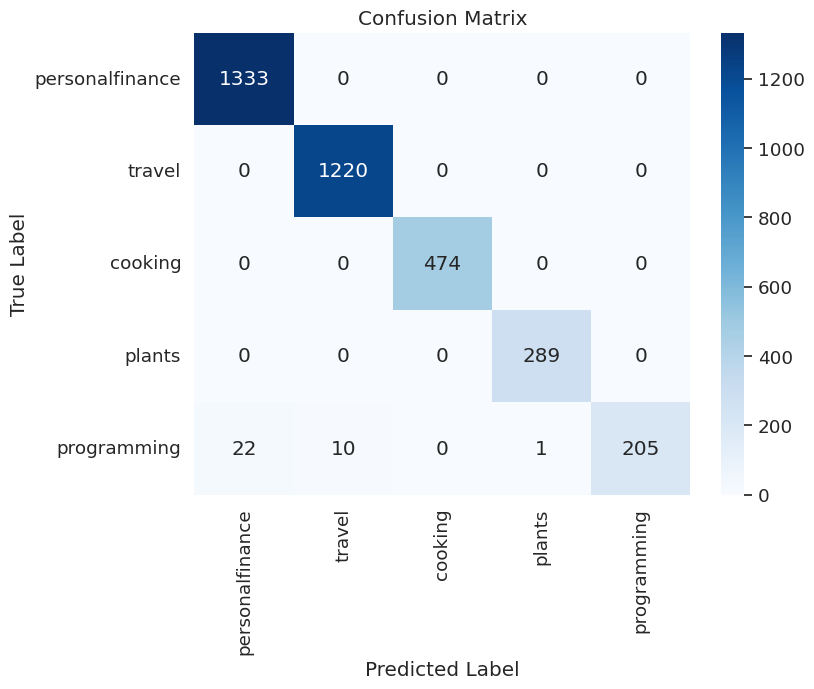

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame predictions to Pandas DataFrame
train_predictions_pd = train_predictions.select('label', 'prediction').toPandas()
valid_predictions_pd = valid_predictions.select('label', 'prediction').toPandas()
test_predictions_pd = test_predictions.select('label', 'prediction').toPandas()

# Get true labels and predicted labels for training, validation, and test data
train_true_labels = train_predictions_pd['label'].tolist()
train_pred_labels = train_predictions_pd['prediction'].tolist()

valid_true_labels = valid_predictions_pd['label'].tolist()
valid_pred_labels = valid_predictions_pd['prediction'].tolist()

test_true_labels = test_predictions_pd['label'].tolist()
test_pred_labels = test_predictions_pd['prediction'].tolist()

# Define labels
labels = ['personalfinance', 'travel', 'cooking','plants','programming' ]  # Replace with your actual labels

# Compute confusion matrix for training data
train_confusion_matrix = confusion_matrix(train_true_labels, train_pred_labels)

# Compute confusion matrix for validation data
valid_confusion_matrix = confusion_matrix(valid_true_labels, valid_pred_labels)

# Compute confusion matrix for test data
test_confusion_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Define function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for training data
plot_confusion_matrix(train_confusion_matrix, labels)

# Plot confusion matrix for validation data
plot_confusion_matrix(valid_confusion_matrix, labels)

# Plot confusion matrix for test data
plot_confusion_matrix(test_confusion_matrix, labels)


In [21]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize Naive Bayes Classifier model
nb = NaiveBayes(featuresCol='features', labelCol='label')

# Fit the model on the training data
nb_model = nb.fit(train_data)

# Make predictions on the test data
predictions = nb_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
nb_accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Naive Bayes Classifier Accuracy:", nb_accuracy)


Naive Bayes Classifier Accuracy: 0.9402227548287043


In [22]:
# Count the total number of labels in training and test sets
train_labels_total_count = train_data.count()
test_labels_total_count = test_data.count()

print("Total number of labels in training set:", train_labels_total_count)
print("Total number of labels in test set:", test_labels_total_count)


Total number of labels in training set: 28351
Total number of labels in test set: 7093


Training Precision: 0.945639097118288
Training Recall: 0.9419420831716695
Training F1 Score: 0.921743885517558

Test Precision: 0.9427315648828121
Test Recall: 0.9402227548287044
Test F1 Score: 0.9182955298614233


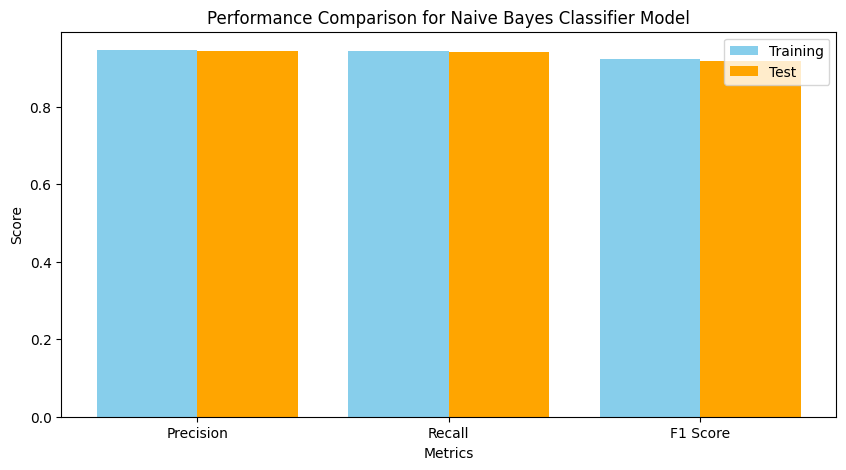

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize Naive Bayes Classifier model
nb = NaiveBayes(featuresCol='features', labelCol='label')

# Fit the model on the training data
nb_model = nb.fit(train_data)

# Make predictions on both training and test data
train_predictions = nb_model.transform(train_data)
test_predictions = nb_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Compute precision, recall, and F1 score for training data
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"})
train_f1_score = evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"})

# Compute precision, recall, and F1 score for test data
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})

# Print precision, recall, and F1 score
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)
print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

# Plot performance for training and test data
labels = ["Precision", "Recall", "F1 Score"]
train_scores = [train_precision, train_recall, train_f1_score]
test_scores = [test_precision, test_recall, test_f1_score]

x = range(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x, train_scores, width=0.4, label="Training", color='skyblue')
plt.bar([i + 0.4 for i in x], test_scores, width=0.4, label="Test", color='orange')
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Performance Comparison for Naive Bayes Classifier Model")
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()
plt.show()


NB VALID

In [21]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training, validation, and test sets (80% train, 10% validation, 10% test)
train_data, test_data, valid_data = assembled_df.randomSplit([0.8, 0.1, 0.1], seed=1234)

# Initialize Naive Bayes Classifier model
nb = NaiveBayes(featuresCol='features', labelCol='label')

# Fit the model on the training data
nb_model = nb.fit(train_data)

# Make predictions on the test data
test_predictions = nb_model.transform(test_data)

# Make predictions on the validation data
valid_predictions = nb_model.transform(valid_data)

# Define the evaluators
evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Evaluate the model on test data
test_accuracy = evaluator.evaluate(test_predictions, {evaluator.metricName: "accuracy"})
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})

# Evaluate the model on validation data
valid_accuracy = evaluator.evaluate(valid_predictions, {evaluator.metricName: "accuracy"})
valid_precision = evaluator.evaluate(valid_predictions, {evaluator.metricName: "weightedPrecision"})
valid_recall = evaluator.evaluate(valid_predictions, {evaluator.metricName: "weightedRecall"})
valid_f1_score = evaluator.evaluate(valid_predictions, {evaluator.metricName: "f1"})

# Print the evaluation results
print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1_score)

print("\nValidation Metrics:")
print("Accuracy:", valid_accuracy)
print("Precision:", valid_precision)
print("Recall:", valid_recall)
print("F1 Score:", valid_f1_score)


Test Metrics:
Accuracy: 0.9392234102419809
Precision: 0.9391539408687087
Recall: 0.9392234102419809
F1 Score: 0.9159964156903684

Validation Metrics:
Accuracy: 0.9412263351229161
Precision: 0.9455597209562235
Recall: 0.9412263351229161
F1 Score: 0.9205214177871198


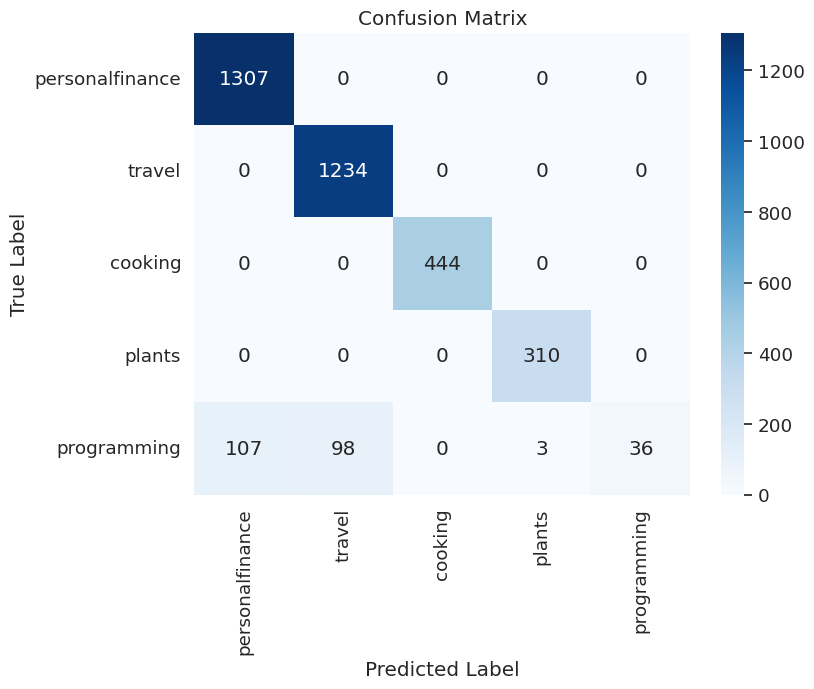

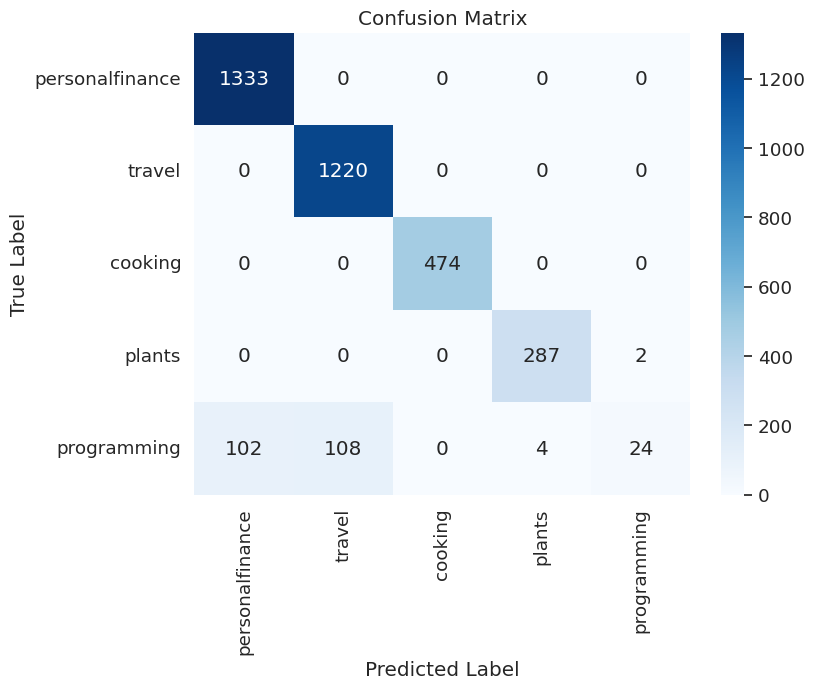

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame predictions to Pandas DataFrame
valid_predictions_pd = valid_predictions.select('label', 'prediction').toPandas()
test_predictions_pd = test_predictions.select('label', 'prediction').toPandas()

# Get true labels and predicted labels for validation and test data
valid_true_labels = valid_predictions_pd['label'].tolist()
valid_pred_labels = valid_predictions_pd['prediction'].tolist()

test_true_labels = test_predictions_pd['label'].tolist()
test_pred_labels = test_predictions_pd['prediction'].tolist()

# Define labels
labels = ['personalfinance', 'travel', 'cooking','plants','programming' ]  # Replace with your actual labels

# Compute confusion matrix for validation data
valid_confusion_matrix = confusion_matrix(valid_true_labels, valid_pred_labels)

# Compute confusion matrix for test data
test_confusion_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Define function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for validation data
plot_confusion_matrix(valid_confusion_matrix, labels)

# Plot confusion matrix for test data
plot_confusion_matrix(test_confusion_matrix, labels)


In [25]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Assemble features (TF-IDF) and labels (one-hot encoded) into a single feature vector
assembler = VectorAssembler(inputCols=["tf_idf_features", "encoded_label"], outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize Decision Tree Classifier model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)

# Fit the model on the training data
dt_model = dt.fit(train_data)

# Make predictions on the test data
predictions = dt_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Decision Tree Classifier Accuracy:", accuracy)


Decision Tree Classifier Accuracy: 1.0


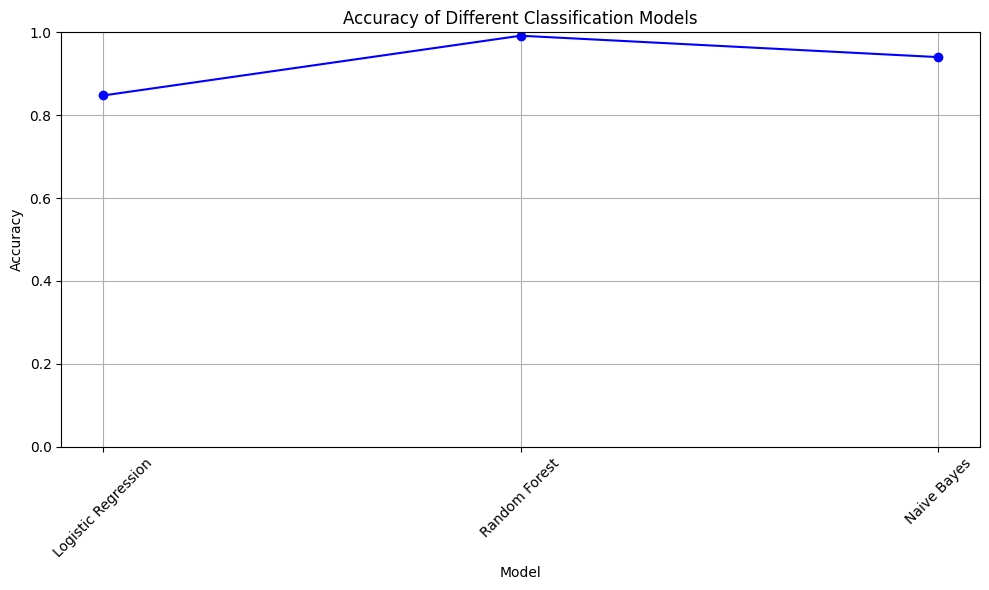

In [26]:
import matplotlib.pyplot as plt

# Model names and their accuracies
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
accuracies = [lr_accuracy, rf_accuracy, nb_accuracy]  # Replace with actual accuracies

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies, marker='o', color='b', linestyle='-')
plt.title('Accuracy of Different Classification Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


LR CONFUSION MATRIX

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on validation and test data
val_predictions = lr_model.transform(val_data)
test_predictions = lr_model.transform(test_data)

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate the model on validation data
val_accuracy = evaluator.evaluate(val_predictions)

# Evaluate the model on test data
test_accuracy = evaluator.evaluate(test_predictions)

# Extract true labels and predicted labels for validation and test data
val_true_labels = np.array(val_predictions.select("label").collect())
val_pred_labels = np.array(val_predictions.select("prediction").collect())

test_true_labels = np.array(test_predictions.select("label").collect())
test_pred_labels = np.array(test_predictions.select("prediction").collect())

# Compute confusion matrix for validation and test data
val_confusion_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_confusion_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Print evaluation results
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("Confusion Matrix:")
print(val_confusion_matrix)

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(test_confusion_matrix)


Validation Metrics:
Accuracy: 0.8423201464170069
Confusion Matrix:
[[2568    0    0    0    0]
 [   0 2461    0    0    0]
 [   0    0  954    0    0]
 [ 619    0    0    0    0]
 [ 501    0    0    0    0]]

Test Metrics:
Accuracy: 0.8475962216269561
Confusion Matrix:
[[2640    0    0    0    0]
 [   0 2454    0    0    0]
 [   0    0  918    0    0]
 [ 599    0    0    0    0]
 [ 482    0    0    0    0]]


In [31]:
# Define function to calculate true positive, false positive, true negative, and false negative counts
def calculate_tp_fp_tn_fn(confusion_matrix):
    tp = confusion_matrix[1, 1]
    fp = confusion_matrix[0, 1]
    tn = confusion_matrix[0, 0]
    fn = confusion_matrix[1, 0]
    return tp, fp, tn, fn

# Calculate true positive, false positive, true negative, and false negative counts for validation data
val_tp, val_fp, val_tn, val_fn = calculate_tp_fp_tn_fn(val_confusion_matrix)

# Calculate true positive, false positive, true negative, and false negative counts for test data
test_tp, test_fp, test_tn, test_fn = calculate_tp_fp_tn_fn(test_confusion_matrix)

# Print the counts
print("Validation True Positives:", val_tp)
print("Validation False Positives:", val_fp)
print("Validation True Negatives:", val_tn)
print("Validation False Negatives:", val_fn)

print("\nTest True Positives:", test_tp)
print("Test False Positives:", test_fp)
print("Test True Negatives:", test_tn)
print("Test False Negatives:", test_fn)


Validation True Positives: 2461
Validation False Positives: 0
Validation True Negatives: 2568
Validation False Negatives: 0

Test True Positives: 2454
Test False Positives: 0
Test True Negatives: 2640
Test False Negatives: 0


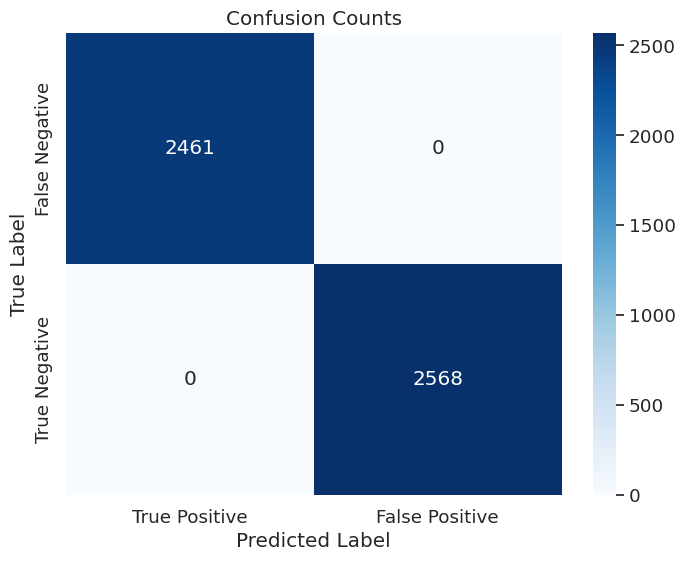

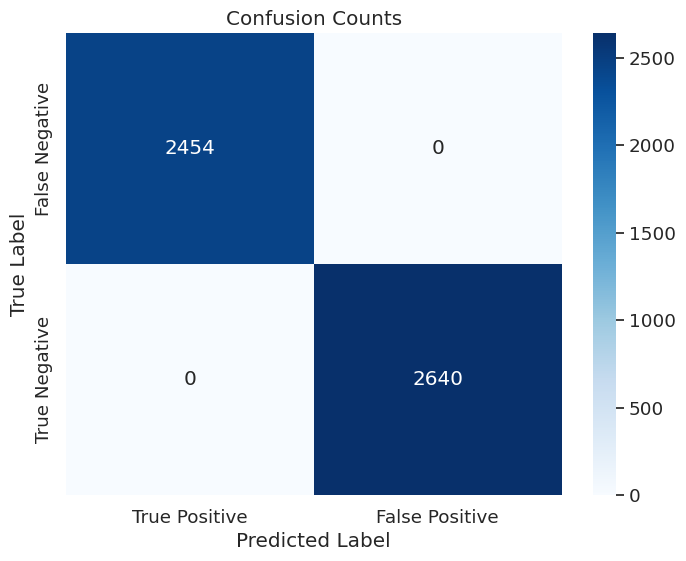

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to visualize true positive, false positive, true negative, and false negative counts
def visualize_confusion_counts(tp, fp, tn, fn):
    counts = [[tp, fp], [fn, tn]]
    labels = [['True Positive', 'False Positive'], ['False Negative', 'True Negative']]

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(counts, annot=True, fmt='g', cmap='Blues', xticklabels=labels[0], yticklabels=labels[1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Counts')
    plt.show()

# Visualize confusion counts for validation data
visualize_confusion_counts(val_tp, val_fp, val_tn, val_fn)

# Visualize confusion counts for test data
visualize_confusion_counts(test_tp, test_fp, test_tn, test_fn)

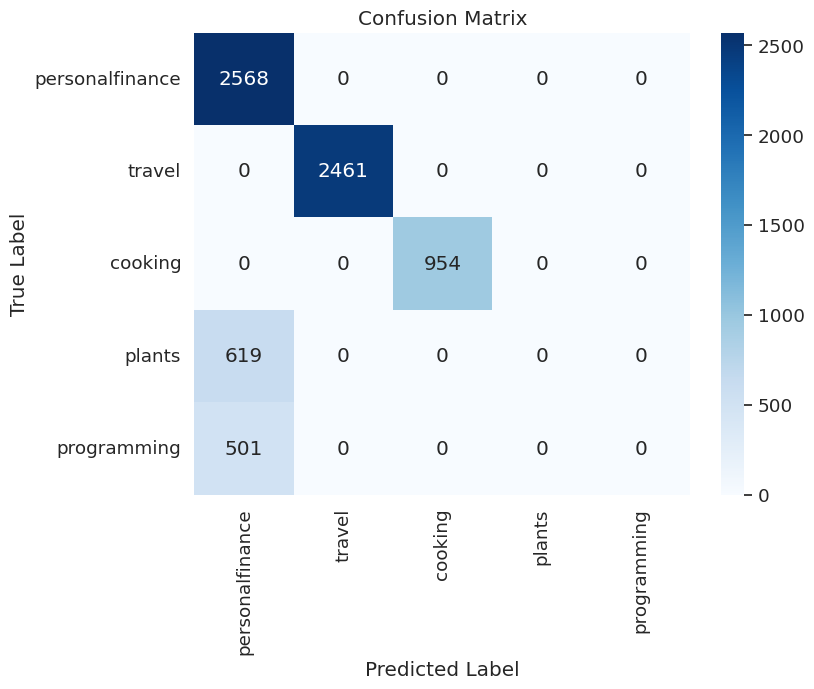

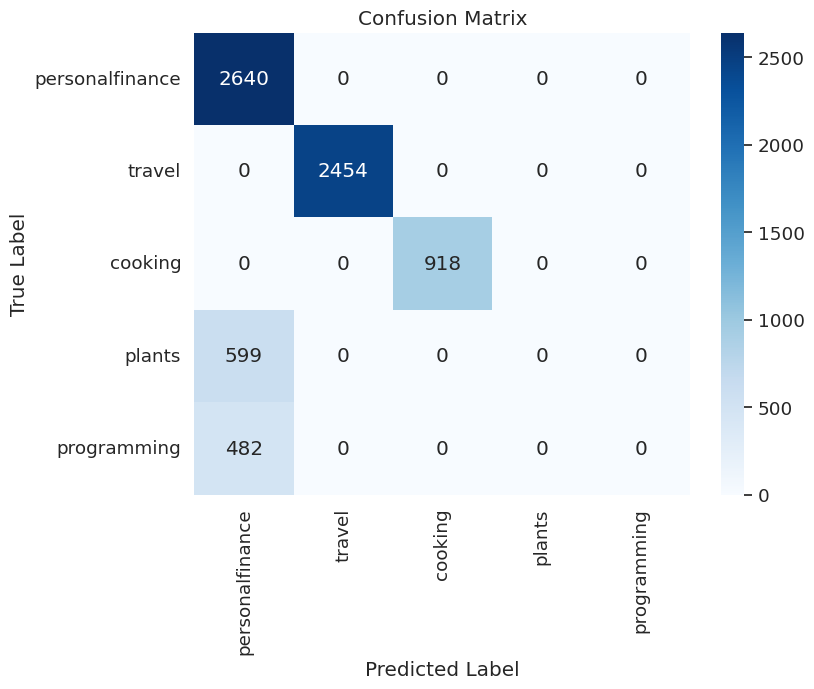

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define labels
labels = ['personalfinance', 'travel', 'cooking','plants','programming' ]  # Replace with your actual labels

# Define function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot d
plot_confusion_matrix(val_confusion_matrix, labels)

# Plot confusion matrix for test data
plot_confusion_matrix(test_confusion_matrix, labels)


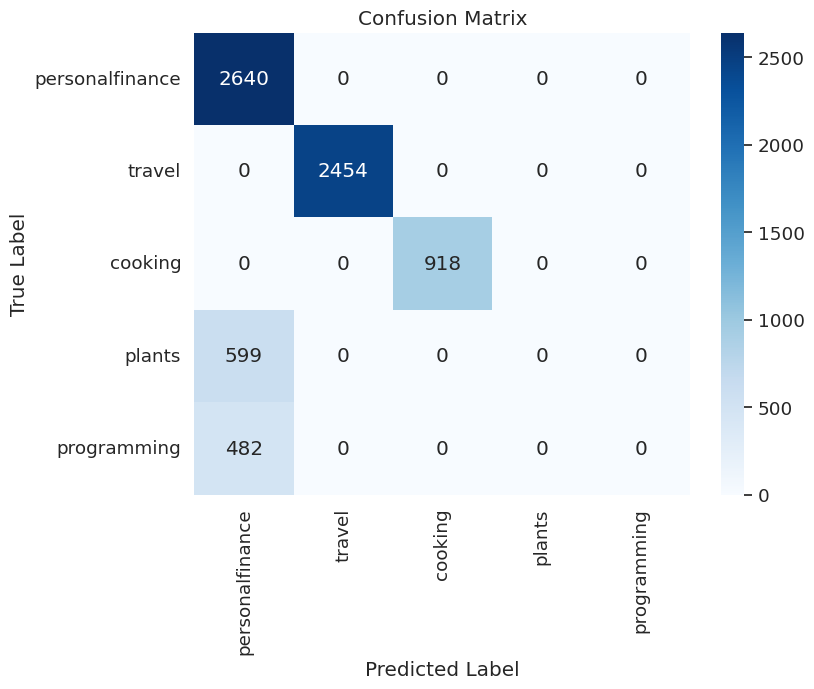

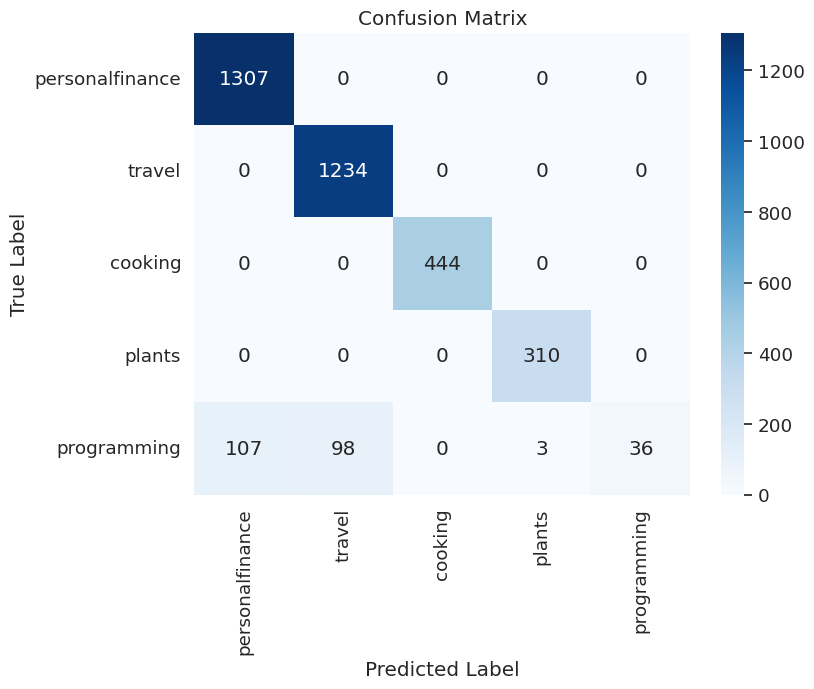

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Convert Spark DataFrame to Pandas DataFrame
test_predictions_pd = test_predictions.select('label', 'prediction').toPandas()
valid_predictions_pd = valid_predictions.select('label', 'prediction').toPandas()

# Get true labels and predicted labels
test_true_labels = test_predictions_pd['label'].tolist()
test_pred_labels = test_predictions_pd['prediction'].tolist()

valid_true_labels = valid_predictions_pd['label'].tolist()
valid_pred_labels = valid_predictions_pd['prediction'].tolist()

# Compute confusion matrix for test data
test_confusion_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Compute confusion matrix for validation data
valid_confusion_matrix = confusion_matrix(valid_true_labels, valid_pred_labels)

# Plot confusion matrix for test data
plot_confusion_matrix(test_confusion_matrix, labels)

# Plot confusion matrix for validation data
plot_confusion_matrix(valid_confusion_matrix, labels)
